In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import roc_curve, confusion_matrix, auc,plot_confusion_matrix,precision_recall_curve, accuracy_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [123]:
conversion=pd.read_csv("conversion_data.csv")

In [124]:
conversion.info()
#no null in all columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [125]:
conversion.describe()
#imbalanced class, mean of 'converted' column only 0.032, most visitors are not converted

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [126]:
#check outliers of age, and remove the outliers
conversion.age.nlargest(n=10)
#Two users age above 100. We need to remove the two users. Wrong data is worrisome and can be an indicator of some bug
#in the logging code. Therefore, I'd like to talk to the software engineer to implemented the code to check if there 
#bugs that affect the data significantly. Here, the issue probably is that users entered wrong data.

90928     123
295581    111
265167     79
192644     77
154217     73
208969     72
114485     70
301366     70
57122      69
168374     69
Name: age, dtype: int64

In [127]:
conversion=conversion[conversion.age<=100]

In [128]:
#summarize categorical data
conversion.source.value_counts()

Seo       155039
Ads        88739
Direct     72420
Name: source, dtype: int64

In [129]:
conversion.country.value_counts()

US         178092
China       76602
UK          48449
Germany     13055
Name: country, dtype: int64

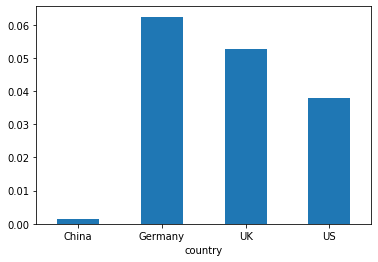

In [130]:
#visualization
#conversion rate by country
country_conversion=conversion.groupby(['country']).converted.mean()
ax = country_conversion.plot.bar(rot=0)
#The conversion rate in China is much lower than the conversion rate elsewhere.

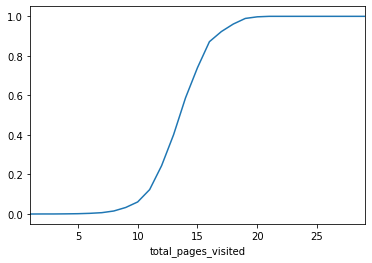

In [131]:
#conversion rate by pageview
page_conversion=conversion.groupby(['total_pages_visited']).converted.mean()
ax = page_conversion.plot.line(rot=0)
#The conversion rate is higher for users who viewed more pages.

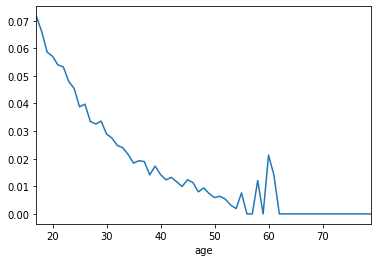

In [132]:
age_conversion=conversion.groupby(['age']).converted.mean()
ax = age_conversion.plot.line(rot=0)
#The conversion rate decreases with age, with spikes around 60 years old.

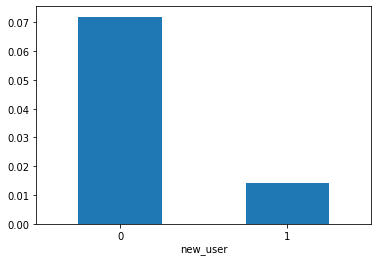

In [249]:
newuser_conversion=conversion.groupby(['new_user']).converted.mean()
ax = newuser_conversion.plot.bar(rot=0)

In [138]:
#preprocessing
conversion_full=pd.get_dummies(conversion,drop_first=True)
y=conversion_full.converted
X=conversion_full.drop('converted',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [177]:
#try logistic regression
#use oversampling to deal with imbalanced data
X = pd.concat([X_train, y_train], axis=1) #concat x_train and y_train
not_converted = X[X.converted==0] #select converted and non_converted records
converted = X[X.converted==1]
#upsample the category with less records, to match the length of the majority category
converted_upsampled = resample(converted,
                          replace=True, # sample with replacement
                          n_samples=len(not_converted), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_converted, converted_upsampled])

In [178]:
upsampled.converted.value_counts()

1    229572
0    229572
Name: converted, dtype: int64

In [179]:
#split back into X_train and y_train and train logistic model
y_train = upsampled.converted
X_train = upsampled.drop('converted', axis=1)

upsampled = LogisticRegression(random_state=10,max_iter=4000).fit(X_train, y_train)
upsampled_pred = upsampled.predict(X_test)
upsampled_pred_prob=upsampled.predict_proba(X_test)[:,1]

0.9400885515496521


In [180]:
accuracy = accuracy_score(y_test, upsampled_pred)
print(accuracy)
auc=roc_auc_score(y_test,upsampled_pred_prob)
print(auc)

0.9859551435356797


In [142]:
coefs=pd.Series(upsampled.coef_[0],index=X_train.columns)
coefs

age                   -0.072140
new_user              -1.714377
total_pages_visited    0.756893
country_Germany        3.950430
country_UK             3.684985
country_US             3.375717
source_Direct         -0.138688
source_Seo            -0.011425
dtype: float64

In [143]:
confusion_matrix(y_test, upsampled_pred)

array([[71834,  4594],
       [  143,  2479]])

In [146]:
fpr, tpr, thresholds = roc_curve(y_test, upsampled_pred_prob)

In [145]:
precision, recall, thresholds = precision_recall_curve(y_test, upsampled_pred_prob)

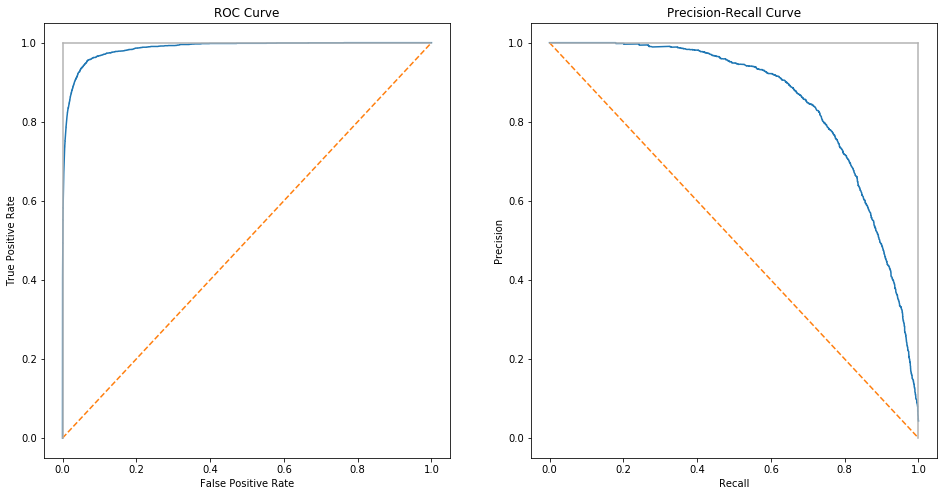

In [167]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("ROC Curve")
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title("Precision-Recall Curve")
plt.plot(recall,precision)
plt.plot([1, 0], ls="--")
plt.plot([1, 1], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [175]:
#random forest
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
y_pred_prob=clf.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_pred_prob)
print(auc)

0.9418722327640734
0.9493035592404523


In [183]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

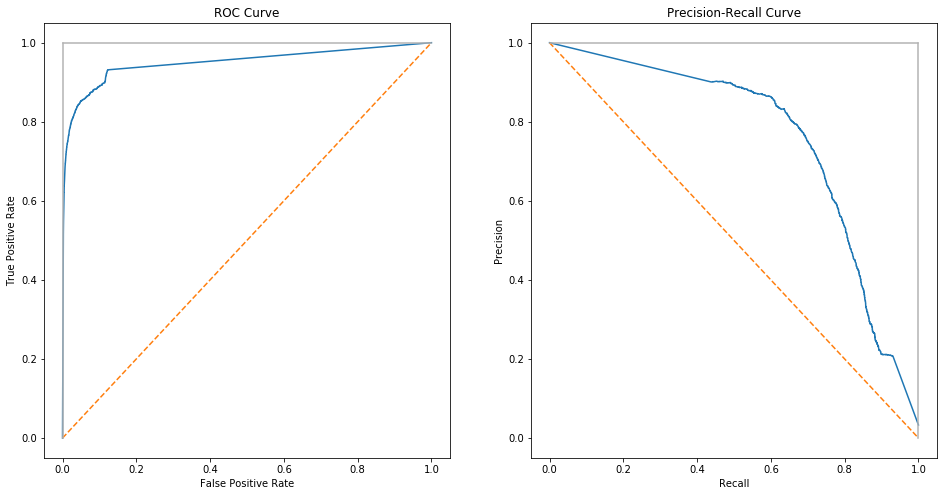

In [184]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("ROC Curve")
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title("Precision-Recall Curve")
plt.plot(recall,precision)
plt.plot([1, 0], ls="--")
plt.plot([1, 1], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [234]:
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': [2, 3, 4],
    'max_depth' : [4,5,6],
    'class_weight': ['balanced_subsample']
}
rfc=RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'class_weight': 'balanced_subsample',
 'max_depth': 6,
 'max_features': 3,
 'n_estimators': 200}

In [236]:
clf2 = RandomForestClassifier(class_weight='balanced_subsample',max_depth=6,max_features=3,n_estimators=200)
clf2.fit(X_train,y_train)
y_pred_2=clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_2)
print(accuracy)
y_pred_prob_2=clf2.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_pred_prob_2)
print(auc)

0.9366729917773561
0.9823830419337053


In [246]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_2)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_2)

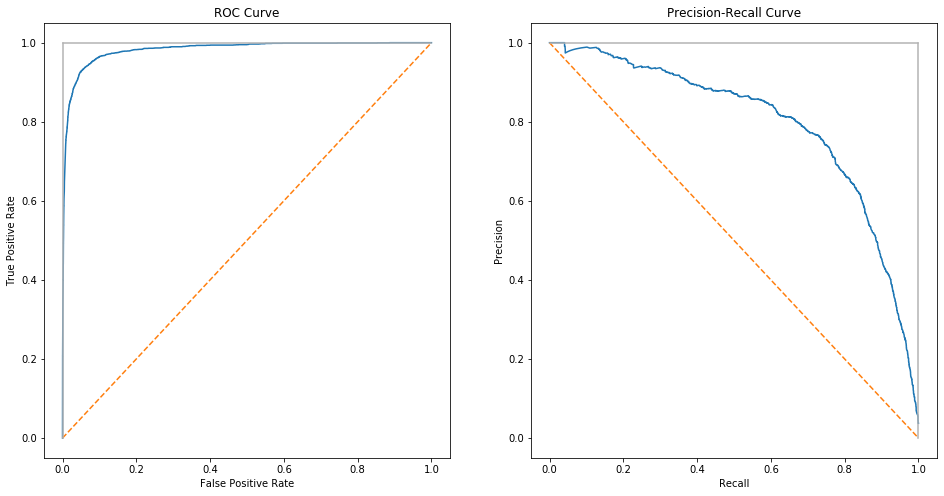

In [247]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("ROC Curve")
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title("Precision-Recall Curve")
plt.plot(recall,precision)
plt.plot([1, 0], ls="--")
plt.plot([1, 1], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Feature ranking:
1. feature 2 (0.833258)
2. feature 1 (0.113431)
3. feature 0 (0.028498)
4. feature 4 (0.009987)
5. feature 5 (0.009043)
6. feature 3 (0.005383)
7. feature 6 (0.000283)
8. feature 7 (0.000119)


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

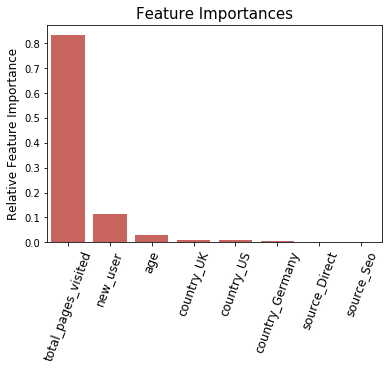

In [240]:
importances = clf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf2.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
sns.barplot(x=X_train.columns[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=12, rotation=70)

In [241]:
#since we can't control the total page visited by users. We take the variable out and build random forest model again
X_train=X_train.drop('total_pages_visited',axis=1)
X_test=X_test.drop('total_pages_visited',axis=1)
clf3 = RandomForestClassifier(class_weight='balanced_subsample')
clf3.fit(X_train,y_train)
y_pred_3=clf3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_3)
print(accuracy)
y_pred_prob_3=clf3.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_pred_prob_3)
print(auc)

0.7280581910183428
0.8046145877783218


In [244]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_3)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_3)

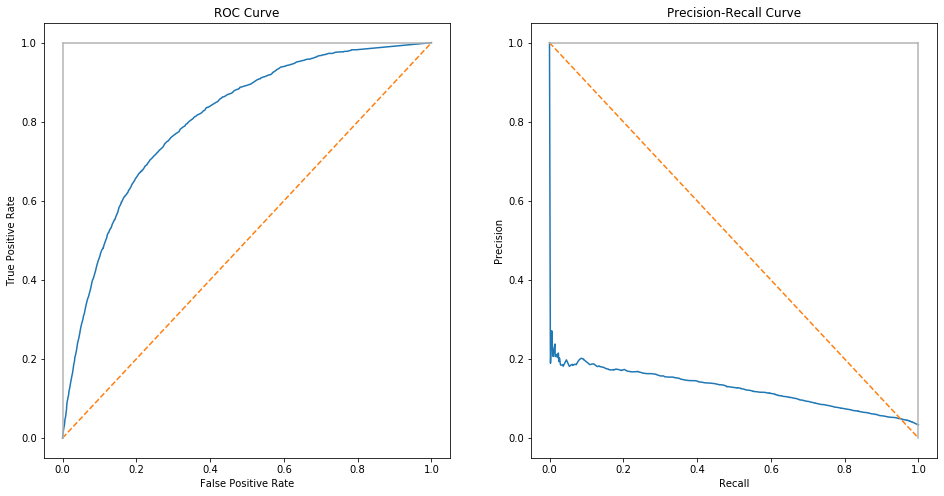

In [245]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("ROC Curve")
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title("Precision-Recall Curve")
plt.plot(recall,precision)
plt.plot([1, 0], ls="--")
plt.plot([1, 1], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Feature ranking:
1. feature 1 (0.445784)
2. feature 0 (0.216890)
3. feature 4 (0.120063)
4. feature 3 (0.113657)
5. feature 2 (0.097425)
6. feature 5 (0.003809)
7. feature 6 (0.002372)


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

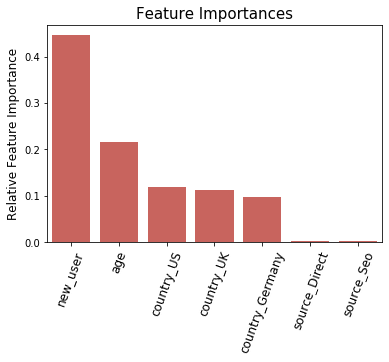

In [248]:
importances = clf3.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf3.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
sns.barplot(x=X_train.columns[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=12, rotation=70)
#new user is the top feature here

Conclusion and Suggestions:
1. The conversion rate is the highest in Germany, but the total user in Germany is much smaller than UK, despite a larger population. The marketing team of the site should expand their effort in Germany.
2. The conversion rate is the lowest in China. It could be caused by English as the main language of the site, or the translation is poor. Since the user base in China is high, it shows people's interest, and it should be a high priority for the site to pinpoint the problem and solve it.
3. The site conversion rate is high for young people. The site should use marketing channels which are more likely to reach young people.
4. The site doesn't work well for older people. Check the UX design to figure out why it doesn't appeal to older people.
5. Old users have higher conversion rate, and it is very important factor of conversion. The marketing team should design targeted emails with offers to bring them back to the site.
6. Someone who has visited many pages, but hasn’t converted, almost surely has high purchase intent. I could email her targeted offers or sending her reminders. Overall, these are probably the easiest users to make convert.